Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

https://www.kaggle.com/competitions/digit-recognizer \
Score: 0.96789

In [23]:
import numpy as np
import pandas as pd
randomSeed=42
np.random.seed(randomSeed)

In [5]:
# from sklearn.datasets import fetch_openml

# mnist = fetch_openml('mnist_784', as_frame=False)
# X, y = mnist.data, mnist.target
# X.shape

In [20]:
data = pd.read_csv("train.csv")
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
y= data["label"].to_numpy()
y.shape

(42000,)

In [34]:
X = data.drop("label",inplace = False,axis=1).to_numpy()
X.shape

(42000, 784)

In [91]:
from sklearn.model_selection import train_test_split
X_train,X_validate,y_train,y_validate= train_test_split(X,y,test_size=0.1,random_state=randomSeed,shuffle=True) #using default
X_train.shape

(37800, 784)

In [131]:
def createNoise(data):
    noise = np.random.randint(0, 100, (len(data), 784))
    return noise
X_noise= createNoise(X_train)+ X_train

In [93]:
from sklearn.preprocessing import StandardScaler
def scale(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data.astype("float64"))
X_scaled= scale(X_train)

In [102]:
from scipy.ndimage import shift
def shiftImage(data):
    return np.array([shift(image.reshape(28,28),[np.random.randint(-3,4),np.random.randint(-3,4)],cval=0).flatten() for image in data])
X_shift= shiftImage(X_train)

In [137]:
def shiftScale(data):
    shifted= shiftImage(data)
    scaled= scale(shifted)
    return scaled
def shiftNoise(data):
    shifted= shiftImage(data)
    noise= createNoise(shifted)
    return shifted+ noise

In [141]:
shiftScaled= shiftScale(X_train[:2])
shiftNoised= shiftNoise(X_train[:2])

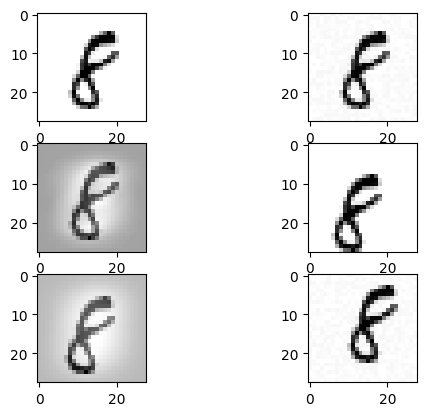

In [139]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(3,2)
axarr[0,0].imshow(X_train[0].reshape(28, 28), cmap="binary")
axarr[0,1].imshow(X_noise[0].reshape(28, 28), cmap="binary")
axarr[1,0].imshow(X_scaled[0].reshape(28, 28), cmap="binary")
axarr[1,1].imshow(X_shift[0].reshape(28, 28), cmap="binary")
axarr[2,0].imshow(shiftScaled[0].reshape(28, 28), cmap="binary")
axarr[2,1].imshow(shiftNoised[0].reshape(28, 28), cmap="binary")
plt.show()

In [75]:
neighbours= 3
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=neighbours)

In [54]:
# from sklearn.model_selection import cross_val_score
# cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")

array([0.96557143, 0.96242857, 0.96742624])

In [143]:
#implementation of cross-val
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

def implement_CV(X_train,y_train):
    folds= StratifiedKFold(n_splits=3)
    accuracy= []
    for train_idx, test_idx in folds.split(X_train,y_train):
        clonedModel= clone(model)
        X_train_folds= X_train[train_idx]
        y_train_folds= y_train[train_idx]
        X_test_folds= X_train[test_idx]
        y_test_folds= y_train[test_idx]
        clonedModel.fit(shiftScale(X_train_folds), y_train_folds)
        y_pred= clonedModel.predict(X_test_folds)
        correct= sum(y_pred==y_test_folds)
        accuracy.append(correct/len(y_pred))
    return accuracy
print(implement_CV(X_train,y_train))

[0.5454761904761904, 0.535079365079365, 0.5463492063492064]


Results comparison:\
Normal: 0.9653174603174604, 0.9617460317460318, 0.9653174603174604\
Scale+Shift: 0.5454761904761904, 0.535079365079365, 0.5463492063492064\
Noise+Shift:0.8834126984126984, 0.8869047619047619, 0.8855555555555555

In [32]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(model, X_train, y_train, cv=3) #return predictions
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[6125,    5,   13,    5,    2,   19,   40,    5,    1,    5],
       [   2, 7018,   21,    4,    4,    2,   11,   10,    3,    2],
       [  79,   67, 5907,   90,   18,    7,   42,   57,   35,   14],
       [  19,   25,   82, 6015,    5,   88,    8,   61,   57,   21],
       [   8,   70,   48,    9, 5788,   10,   24,   31,    8,  217],
       [  33,   12,   25,  172,   27, 5197,   88,   13,   46,   42],
       [  74,   18,   26,    5,   12,   43, 6012,    1,    8,    0],
       [  11,   74,   47,   17,   67,    6,    0, 6138,    5,  204],
       [  56,   85,   55,  153,   54,  178,   26,   22, 5446,   57],
       [  21,   19,   34,   56,  139,   24,    0,  201,   16, 5728]],
      dtype=int64)

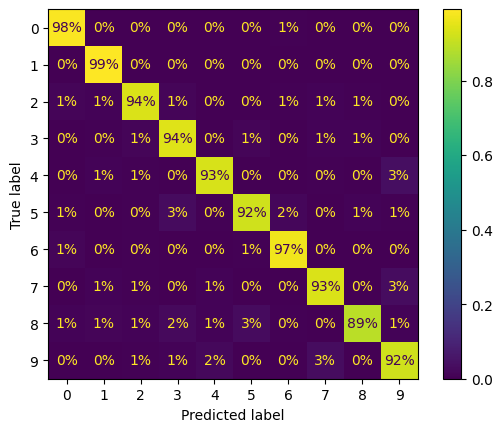

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.show()

In [27]:
from sklearn.metrics import f1_score
f1_score(y_train,y_train_pred,average="weighted") #combines precision and recall

0.9698555361432526

In [ ]:
#Others- precision recall tradeoff by adjusting threshold

In [145]:
from sklearn.model_selection import GridSearchCV
parameters = {'weights':('uniform', 'distance'), 'n_neighbors':[1, 5]}
model=KNeighborsClassifier()
gs = GridSearchCV(model, parameters)
gs.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 5],
                         'weights': ('uniform', 'distance')})

In [146]:
print(gs.best_params_)

{'n_neighbors': 5, 'weights': 'distance'}


In [147]:
from sklearn.metrics import f1_score
latestModel=KNeighborsClassifier(**gs.best_params_)
latestModel.fit(X_train,y_train)
y_val_pred= latestModel.predict(X_validate)
f1_score(y_validate,y_val_pred,average="weighted") #combines precision and recall

0.9663870072254788

In [148]:
X_test= pd.read_csv("test.csv")
X_test.shape

(28000, 784)

In [149]:
latestModel=KNeighborsClassifier(**gs.best_params_)
latestModel.fit(X,y)
y_test_pred= latestModel.predict(X_test)

c:\Users\yufei\Desktop\Coding\Machine Learning\Machine-Learning\env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [150]:
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Label': y_test})
    df.index += 1 # Ensures that the index starts at 1
    df.to_csv('mnist_submission.csv', index_label='ImageId')
results_to_csv(y_test_pred)